# 🧪 Leave-X-Out (LXO) Subsampling Strategy — Sampling Plan Generation

## 🎯 Goal

This notebook generates **sampling masks** for each patient and each LXO configuration, to enable **uncertainty quantification via structured k-space dropout**.

The LXO method removes a fixed subset of **phase-encoding lines** from the k-space data in each sub-reconstruction. By varying which lines are left out in each sub-sample, we can simulate multiple plausible reconstructions and compute voxelwise standard deviation (UQ map).

---

## 📐 What This File Does

For every patient:
1. Load the k-space
2. Define a set of **LXO sampling masks** — each one represents a sub-reconstruction where specific echo trains (lines) are removed
3. Store:
   - Patient ID
   - Acceleration factor
   - LXO config (e.g. `X=4` 4 echo trains are left out)
   - For each sub-reconstruction: the **retained line indices**

---

## 🗂️ Output

We save the sampling index information in a **SQLite database**, so that later:
- During inference, we can load the sampling masks per patient/sub-reconstruction
- The DL model can reconstruct from **only the retained lines** per sub-sample
- UQ maps can be generated via **voxelwise std-dev** over sub-reconstructions

---

## 📊 Why This Matters

Unlike Gaussian noise-based UQ, LXO targets **structured sensitivity** to missing k-space regions — which may better simulate real-world signal variations and improve correlation with hallucination-prone areas.

---


In [1]:
from pathlib import Path
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math
from typing import List, Dict, Tuple, Union


# All patient IDs to consider for Uncertainty Quantification
pat_ids = [
    '0003_ANON5046358',
    # '0004_ANON9616598',
    # '0005_ANON8290811',
    # '0006_ANON2379607',
    # '0007_ANON1586301',
    # '0008_ANON8890538',
    # '0010_ANON7748752',
    # '0011_ANON1102778',
    # '0012_ANON4982869',
    # '0013_ANON7362087',
    # '0014_ANON3951049',
    # '0015_ANON9844606',
    # '0018_ANON9843837',
    # '0019_ANON7657657',
    # '0020_ANON1562419',
    # '0021_ANON4277586',
    # '0023_ANON6964611',
    # '0024_ANON7992094',
    # '0026_ANON3620419',
    # '0027_ANON9724912',
    # '0028_ANON3394777',
    # '0029_ANON7189994',
    # '0030_ANON3397001',
    # '0031_ANON9141039',
    # '0032_ANON7649583',
    # '0033_ANON9728185',
    # '0035_ANON3474225',
    # '0036_ANON0282755',
    # '0037_ANON0369080',
    # '0039_ANON0604912',
    # '0042_ANON9423619',
    # '0043_ANON7041133',
    # '0044_ANON8232550',
    # '0045_ANON2563804',
    # '0047_ANON3613611',
    # '0048_ANON6365688',
    # '0049_ANON9783006',
    # '0051_ANON1327674',
    # '0052_ANON9710044',
    # '0053_ANON5517301',
    # '0055_ANON3357872',
    # '0056_ANON2124757',
    # '0057_ANON1070291',
    # '0058_ANON9719981',
    # '0059_ANON7955208',
    # '0061_ANON7642254',
    # '0062_ANON0319974',
    # '0063_ANON9972960',
    # '0064_ANON0282398',
    # '0067_ANON0913099',
    # '0068_ANON7978458',
    # '0069_ANON9840567',
    # '0070_ANON5223499',
    # '0071_ANON9806291',
    # '0073_ANON5954143',
    # '0075_ANON5895496',
    # '0076_ANON3983890',
    # '0077_ANON8634437',
    # '0078_ANON6883869',
    # '0079_ANON8828023',
    # '0080_ANON4499321',
    # '0081_ANON9763928',
    # '0082_ANON6073234',
    # '0083_ANON9898497',
    # '0084_ANON6141178',
    # '0085_ANON4535412',
    # '0086_ANON8511628',
    # '0087_ANON9534873',
    # '0088_ANON9892116',
    # '0089_ANON9786899',
    # '0090_ANON0891692',
    # '0092_ANON9941969',
    # '0093_ANON9728761',
    # '0094_ANON8024204',
    # '0095_ANON4189062',
    # '0097_ANON5642073',
    # '0103_ANON8583296',
    # '0104_ANON7748630',
    # '0105_ANON9883201',
    # '0107_ANON4035085',
    # '0108_ANON0424679',
    # '0109_ANON9816976',
    # '0110_ANON8266491',
    # '0111_ANON9310466',
    # '0112_ANON3210850',
    # '0113_ANON9665113',
    # '0115_ANON0400743',
    # '0116_ANON9223478',
    # '0118_ANON7141024',
    # '0119_ANON3865800',
    # '0120_ANON7275574',
    # '0121_ANON9629161',
    # '0123_ANON7265874',
    # '0124_ANON8610762',
    # '0125_ANON0272089',
    # '0126_ANON4747182',
    # '0127_ANON8023509',
    # '0128_ANON8627051',
    # '0129_ANON5344332',
    # '0135_ANON9879440',
    # '0136_ANON8096961',
    # '0137_ANON8035619',
    # '0138_ANON1747790',
    # '0139_ANON2666319',
    # '0140_ANON0899488',
    # '0141_ANON8018038',
    # '0142_ANON7090827',
    # '0143_ANON9752849',
    # '0144_ANON2255419',
    # '0145_ANON0335209',
    # '0146_ANON7414571',
    # '0148_ANON9604223',
    # '0149_ANON4712664',
    # '0150_ANON5824292',
    # '0152_ANON2411221',
    # '0153_ANON5958718',
    # '0155_ANON7828652',
    # '0157_ANON9873056',
    # '0159_ANON9720717',
    # '0160_ANON3504149'
]

roots = {
    'kspace':            Path('/scratch/p290820/datasets/003_umcg_pst_ksps'),
    'reader_study':      Path('/scratch/hb-pca-rad/projects/03_reader_set_v2'),
    'reader_study_segs': Path('/scratch/hb-pca-rad/projects/03_reader_set_v2/segs'),
    'R3_gaussian':       Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_{3}x"),
    'R6_gaussian':       Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_{6}x"),
    'db_fpath_old':      Path('/scratch/p290820/datasets/003_umcg_pst_ksps/database/dbs/master_habrok_20231106_v2.db'),                  # References an OLDER version of the databases where the info could also just be fine that we are looking for
    'db_fpath_new':      Path('/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/databases/master_habrok_20231106_v2.db'),    # References the LATEST version of the databases where the info could also just be fine that we are looking for
    'figures_gaussian':  Path('/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/figures'),
    'figures_lxo':       Path('/scratch/hb-pca-rad/projects/04_uncertainty_quantification/lxo/figures'),
}


def load_kspace_data(pid: str, kspace_root: Path) -> Tuple[np.ndarray, str]:
    """
    Load k-space data and ISMRMRD headers from h5 file

    Parameters:
        pid (str): Patient ID.
        kspace_root (Path): Root directory for k-space data.

    Returns:
        Tuple[np.ndarray, str]: A tuple containing the k-space data and the ISMRMRD header string.
    """
    kspace_dir = kspace_root / 'data' / pid / 'h5s'
    kspace_files = list(kspace_dir.glob("*.h5"))
    assert len(kspace_files) == 1, f"Expected 1 kspace file for {pid}, found {len(kspace_files)}"
    
    print(f"Loading kspace data from {kspace_files[0]}")
    with h5py.File(kspace_files[0], 'r') as f:
        kspace = f['kspace'][:]
        header_dataset = f['ismrmrd_header']
        header_str = header_dataset.asstr()[()]
    print(f"Loaded kspace shape: {kspace.shape}, for patient {pid}")
    return kspace, header_str


# Exploration
Take the first average and see which lines in the column direction are sampled. 
This is k-space data, lets visualize which lines are sampled because i believe only half the lines are measured. Lets see in the row and column direction which way the lines are measured in row or col direction and then see which have been sampled.

Loaded kspace shape: (3, 30, 20, 768, 651), for patient 0003_ANON5046358


/tmp/ipykernel_2713798/1636304141.py:7: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(kspace[avg1, slice_idx, coil_idx, :, :])), cmap='gray', aspect='auto')


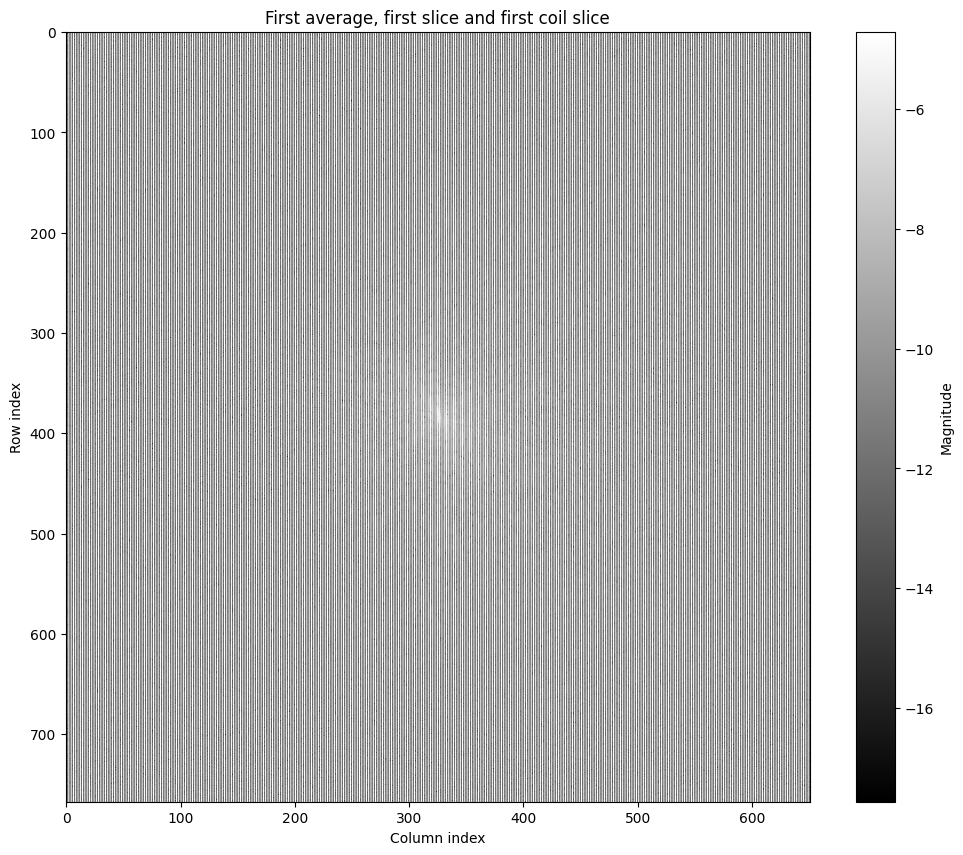

In [2]:
avg1, avg2, avg3 = 0, 1, 2
slice_idx = 0
coil_idx = 0
kspace, headers = load_kspace_data(pat_ids[0], roots['kspace'])

plt.figure(figsize=(24//2, 20//2))
plt.imshow(np.log(np.abs(kspace[avg1, slice_idx, coil_idx, :, :])), cmap='gray', aspect='auto')
plt.title(f"First average, first slice and first coil slice")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.colorbar(label="Magnitude")
plt.show()

In [3]:
# --- Helper stubs (assume these are defined elsewhere in your notebook) ---
# fetch_echo_train_columns(patient_id, avg_idx, echo_train_idx, db_path, table_name) -> np.ndarray
# count_distinct_echo_trains(patient_id, db_path) -> int
# find_middle_echo_train(n_cols, echo_train_summary_df) -> Tuple[int, int]
# fetch_echo_train_summary(patient_id, db_path, table_name, slice_index, debug) -> pd.DataFrame
# -----------------------------------------------------------------------------


def generate_r3_undersampled_kspaces(
    full_kspace: np.ndarray,
    patient_id: str,
    db_path: Path,
    echo_train_table: str,
    average_index: int = 0
) -> List[np.ndarray]:
    """
    Create R=3 undersampled k‑space variants by dropping two echo‑trains at a time,
    never omitting the echo‑train containing the k‑space center line.

    Parameters
    ----------
    full_kspace : np.ndarray
        Shape (n_avgs, n_slices, n_coils, n_rows, n_cols).
    patient_id : str
    db_path : Path
    echo_train_table : str
    average_index : int, default 0

    Returns
    -------
    undersampled_kspaces : List[np.ndarray]
        Each element is a copy of full_kspace[average_index] with two echo‑trains zeroed out.
    """
    # 1) Load echo‐train summary and count
    et_df = fetch_echo_train_summary(patient_id, db_path, echo_train_table, slice_index=0, debug=False)
    total_echo_trains = count_distinct_echo_trains(patient_id, db_path, echo_train_table, average_index)
    print(f"  • found {total_echo_trains} echo trains")

    # 2) Pick out the average
    ksp_avg = full_kspace[average_index]  # shape (n_slices, n_coils, n_rows, n_cols)
    n_cols = ksp_avg.shape[-1]
    print(f"  • k‑space shape for avg {average_index}: {ksp_avg.shape}")
    print(f"  • found n_cols={n_cols} columns")

    # 3) Identify center echo‐train (contains middle column)
    _, center_et = find_middle_echo_train(n_cols, et_df)
    print(f"  • center echo‐train index: {center_et}")

    # 4) Build map variant_idx → two echo‐trains to drop
    valid_ets = [et for et in range(total_echo_trains) if et != center_et]
    n_variants = len(valid_ets) // 2
    echo_train_dropout_map = {
        idx: valid_ets[2*idx : 2*idx + 2]
        for idx in range(n_variants)
    }
    print(f"  • Echo-train dropout plan: {echo_train_dropout_map}")

    # 5) Generate undersampled sets
    undersampled_sets = []
    for variant_idx, ets_to_drop in echo_train_dropout_map.items():
        # fetch & concatenate their column indices
        cols_drop = np.concatenate([
            fetch_echo_train_columns(
                patient_id, average_index, et_idx, db_path, echo_train_table
            )
            for et_idx in ets_to_drop
        ])
        cols_drop = np.unique(cols_drop)
        print(f"    Variant {variant_idx}: dropping {len(cols_drop)} lines (first 5 → {cols_drop[:5]}) (last 5 → {cols_drop[-5:]})")

        # zero out in one shot
        ksp_copy = ksp_avg.copy()
        ksp_copy[..., cols_drop] = 0
        undersampled_sets.append(ksp_copy)

    return undersampled_sets, echo_train_dropout_map


def plot_undersampled_reconstructions(
    undersampled_kspaces: List[np.ndarray],
    echo_train_dropout_map: Dict[int, List[int]],
    slice_index: int = 0,
    coil_combine=True,
    grid_shape: Tuple[int, int] = (2, 3)
):
    """
    Plot a grid of reconstructed images from undersampled k-space variants,
    with additional uncertainty maps (STD and Coefficient of Variation).

    Parameters
    ----------
    undersampled_kspaces : List[np.ndarray]
        List of k-space arrays, each with shape (nslices, ncoils, nrows, ncols).
    echo_train_dropout_map : Dict[int, List[int]]
        Mapping from variant index to list of dropped echo train indices.
    slice_index : int
        Slice to display.
    coil_combine : bool
        If True, apply root-sum-of-squares coil combination.
    grid_shape : (int, int)
        Grid shape for reconstructions (rows, cols).
    """
    n_variants = len(undersampled_kspaces)
    nrows, ncols = grid_shape
    assert nrows * ncols >= n_variants, "Grid shape too small for number of variants"

    # Reconstruct all images
    recon_images = []
    for ksp in undersampled_kspaces:
        ksp_slice = ksp[slice_index]
        img = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(ksp_slice, axes=(-2, -1))), axes=(-2, -1))
        if coil_combine:
            img_comb = np.sqrt(np.sum(np.abs(img) ** 2, axis=0))
        else:
            img_comb = np.abs(img[0])
        recon_images.append(img_comb)

    recon_images = np.stack(recon_images, axis=0)  # shape: (n_recons, H, W)
    print(f"Reconstructed images shape: {recon_images.shape}")

    # Compute uncertainty maps
    std_map = np.std(recon_images, axis=0)
    mean_map = np.mean(recon_images, axis=0)
    cv_map = np.divide(std_map, mean_map + 1e-8)  # add epsilon to avoid div by zero

    # Total rows = original + 1 (for uncertainty maps)
    total_rows = nrows + 1
    fig, axes = plt.subplots(total_rows, ncols, figsize=(ncols * 3, total_rows * 3))

    # Plot all reconstructions
    for idx in range(n_variants):
        ax = axes[idx // ncols, idx % ncols]
        ax.imshow(recon_images[idx], cmap='gray', interpolation='nearest')
        ax.axis('off')
        ets = echo_train_dropout_map[idx]
        ax.text(0.05, 0.05, f"Recon {idx}\nDrop ET: {ets}", color='yellow', transform=ax.transAxes)

    # Plot STD and CV maps in last row
    ax_std = axes[-1, 0]
    ax_cv = axes[-1, 1]
    ax_std.imshow(std_map, cmap='magma')
    ax_std.set_title("Uncertainty (STD)")
    ax_std.axis('off')
    ax_cv.imshow(cv_map, cmap='magma')
    ax_cv.set_title("Uncertainty (CV)")
    ax_cv.axis('off')

    # Turn off any unused axes
    for i in range(n_variants, nrows * ncols):
        axes[i // ncols, i % ncols].axis('off')
    for j in range(2, ncols):
        axes[-1, j].axis('off')

    plt.tight_layout()
    plt.show()



# --- Example usage ---
kspace = kspaces[0]['kspace']   # loaded earlier
pid = kspaces[0]['id']          # loaded earlier
accel_factors = [3]             # R=3 case only

print(f"Patient ID: {pid}")
print(f"Acceleration Factor: {accel_factors[0]}")
for R in accel_factors:
    print(f"→ Patient {pid}, acceleration R={R}")
    undersampled_kspaces, et_dropout_map = generate_r3_undersampled_kspaces(
        full_kspace      = kspace,
        patient_id       = pid,
        db_path          = roots['db_fpath_new'],
        echo_train_table = tablename,
        average_index    = 0
    )
    print(f"Generated {len(undersampled_kspaces)} undersampled k‑spaces for R=3")
print(f"Undersampled k-space shape: {undersampled_kspaces[0].shape}")

plot_undersampled_reconstructions(
    undersampled_kspaces,
    et_dropout_map,
    slice_index=16,
    grid_shape=(2, 3),
    coil_combine=True
)

NameError: name 'kspaces' is not defined

⚠️ Echo-Train Dropout at R=6: Key Considerations
In the vSHARP setup, R=6 is achieved by:

Using only 1 average out of 3 (each average samples distinct lines),

Combined with a Cartesian R=4 mask applied during reconstruction.

This has important implications for echo-train dropout:

🎯 What We've Learned:
The Cartesian R=4 mask selects every 4th column (e.g., even indices), possibly with an offset.

Each average contains only half of the k-space lines (e.g., avg0 = odd lines, avg1 = even lines, avg2 = mixed or repeated).

If we select an average whose lines don’t align with the R=4 mask, almost no data remains after masking.

This leads to empty or black images when performing echo-train dropout → unusable for UQ.

✅ Therefore:
To ensure echo-train dropout works at R=6:

We must select an average that retains sufficient columns after masking.

Empirically, average 2 (index = 2) works well with vSHARP’s masking scheme and retains usable data.


⚖️ Implications for Fair Comparison:
For Gaussian UQ, both R=3 and R=6 reconstructions typically use average 0.

For Leave-X-Out UQ:

R=3 uses average 0 with echo-train dropout.

R=6 must use average 2, otherwise echo-train dropout fails.

⚠️ This introduces a small asymmetry:
We're comparing different averages (avg0 vs avg2) between methods.

However, this is a practical necessity, not a conceptual flaw.

You may justify this by:

Arguing that the averages are interchangeable in terms of anatomy,

And you're comparing UQ strategies, not sampling consistency.

# Instead of cartesian sampling to reach R=6, we will accelerate by leaving out echo trains.


# Functions - 🧪 Leave-X-Out (LXO) Echo Train Subsampling Strategy (R=3)

We aim to generate uncertainty maps by leaving out a structured subset of echo trains per sub-reconstruction.

For example, if a patient has **13 echo trains**, we perform approximately half that number of reconstructions:

- `13 // 2 = 6` reconstructions
- In each sub-reconstruction, a different echo train is left out
- The **echo train that contains the central k-space line** is always retained to preserve image contrast

### 🔢 Example:
Given echo train indices:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]




Assume the central k-space line lies in **echo train index 2**.

The sub-reconstruction plans might look like:

- `recon1`: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
- `recon2`: [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]
- `recon3`: [0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12]
- `recon4`: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12]
- `recon5`: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12]
- `recon6`: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Each reconstruction retains all echo trains **except two**, except the center-containing echo train (index 2), which is **never dropped**.


In [2]:
from typing import Optional


def fetch_echo_train_summary(
    patient_id: str,
    db_path: Union[str, Path],
    table_name: str,
    slice_index: int = 0,
    debug: bool = False
) -> pd.DataFrame:
    """
    Fetch per‑echo‑train column‑index summaries for a given patient & slice.

    Parameters
    ----------
    patient_id : str
        The seq_id of the patient.
    db_path : str or Path
        Path to the SQLite database file.
    table_name : str
        Name of the table containing acquisitions.
    slice_index : int, default=0
        Which slice to filter on (usually 0 for mapping).
    debug : bool, default=False
        If True, prints the resulting DataFrame.

    Returns
    -------
    pd.DataFrame
        Columns: ['id','avg_idx','echo_train_idx','col_indexes','sample_count'].
        - col_indexes is a comma‑separated string of the sampled column indices.
        - sample_count should equal the echo‑train length (e.g. 25).

    Raises
    ------
    ValueError
        If no rows are returned for the given patient & slice.
    RuntimeError
        On any database I/O error.
    """
    db_file = str(db_path)
    sql = f"""
    SELECT
      id,
      avg_idx,
      echo_train_idx,
      GROUP_CONCAT(col_idx, ',') AS col_indexes,
      COUNT(col_idx)             AS sample_count
    FROM {table_name}
    WHERE id   = ?
      AND slice_idx = ?
    GROUP BY avg_idx, echo_train_idx
    ORDER BY avg_idx, echo_train_idx
    ;
    """

    try:
        with sqlite3.connect(db_file) as conn:
            df = pd.read_sql_query(sql, conn, params=(patient_id, slice_index))
    except sqlite3.Error as e:
        raise RuntimeError(f"Unable to query echo‑train mapping: {e}")

    if df.empty:
        raise ValueError(
            f"No echo‑train summary found for patient={patient_id!r}, slice_idx={slice_index}"
        )

    if debug:
        print(f"[DEBUG] Echo‑train summary for {patient_id!r}, slice {slice_index}:\n", df)

    return df


def count_distinct_echo_trains(
    patient_id: str,
    db_filepath: Union[str, Path],
    table_name: str,
    average_index: int = 0,
) -> int:
    """
    Count how many distinct echo trains were acquired for slice 0 of the first average.

    Parameters
    ----------
    patient_id : str
        The patient sequence ID (seq_id in the DB).
    db_filepath : str or Path
        Path to the SQLite database file.
    table_name : str
        Name of the table containing echo‑train mapping.

    Returns
    -------
    int
        The number of distinct echo_train_idx found.

    Raises
    ------
    RuntimeError
        If there is any database I/O error.
    ValueError
        If the query returns no result (should not normally happen).
    """
    db_path = str(db_filepath)
    sql = f"""
    SELECT COUNT(DISTINCT echo_train_idx) 
      FROM {table_name}
     WHERE id = ?
       AND avg_idx  = ?
       AND slice_idx = 0
    ;
    """

    try:
        with sqlite3.connect(db_path) as conn:
            cursor = conn.execute(sql, (patient_id, average_index))
            row = cursor.fetchone()
    except sqlite3.Error as e:
        raise RuntimeError(f"Database error counting echo trains: {e}")

    if row is None or row[0] is None:
        raise ValueError(
            f"No echo‑train entries found for patient={patient_id!r}, avg_idx=0, slice_idx=0"
        )

    # we expect a number anywere between 1 and 30 ish
    if row[0] < 1 or row[0] > 30:
        raise ValueError(
            f"Unexpected number of echo trains for patient={patient_id!r}: {row[0]}. we assert this is between 1 and 30. (please inspect this case)"
        )

    print(f"Found {row[0]} distinct echo trains for patient {patient_id!r}, avg_idx={average_index}, slice_idx=0")
    return int(row[0])


def find_middle_echo_train(
    ncols: int,
    summary_df: pd.DataFrame
) -> Tuple[int, int]:
    """
    Find which echo‑train (and which average) acquired the exact center ky line.

    Parameters
    ----------
    ncols : int
        Total number of k‑space columns (e.g. 651)
    summary_df : pd.DataFrame
        Output of fetch_echo_train_summary(), with columns:
        ['seq_id','avg_idx','echo_train_idx','col_indexes','sample_count']

    Returns
    -------
    (avg_idx, echo_train_idx)
        The average and echo‑train index that contains column ncols//2.

    Raises
    ------
    ValueError
        If no echo train contains the exact center column.
    """
    middle_col = ncols // 2
    print(f"Middle column Found to be: {middle_col}")
    # print(summary_df)
    for _, row in summary_df.iterrows():
        # turn "12,13,14,..." into [12,13,14,…]
        cols = list(map(int, row["col_indexes"].split(",")))
        if middle_col in cols:
            print(f"Found middle column {middle_col} in avg {row['avg_idx']}, echo train {row['echo_train_idx']}")
            return int(row["avg_idx"]), int(row["echo_train_idx"])

    raise ValueError(f"No echo train found containing center column {middle_col}")


def fetch_echo_train_columns(
    patient_id: str,
    average_index: int,
    echo_train_index: int,
    db_filepath: Union[str, Path],
    table_name: str
) -> np.ndarray:
    """
    Retrieve the list of k‑space column indices for a single echo train
    (slice 0) of a given patient & average.

    Parameters
    ----------
    patient_id : str
        Unique patient identifier (seq_id in DB).
    average_index : int
        Which average repetition (cAve) to query.
    echo_train_index : int
        Which echo train number to query.
    db_filepath : str or Path
        Path to the SQLite database file.
    table_name : str
        Name of the table holding echo‑train mapping.

    Returns
    -------
    np.ndarray[int]
        1D array of column indices, sorted by their acquisition order.

    Raises
    ------
    RuntimeError
        On any database I/O error.
    ValueError
        If no rows are found, or the count != expected echo‑train length.
    TypeError
        If any retrieved index is not integer‑castable.
    """
    EXPECTED_ECHO_TRAIN_LENGTH = 25
    db_path_str = str(db_filepath)

    sql = f"""
    SELECT col_idx
      FROM {table_name}
     WHERE id             = ?
       AND avg_idx        = ?
       AND echo_train_idx = ?
       AND slice_idx      = 0
     ORDER BY inner_et_counter ASC
    ;
    """

    try:
        with sqlite3.connect(db_path_str) as conn:
            cursor = conn.execute(sql, (patient_id, average_index, echo_train_index))
            rows = cursor.fetchall()
    except sqlite3.Error as err:
        raise RuntimeError(f"Failed to query DB: {err}")

    if not rows:
        raise ValueError(
            f"No columns found for patient={patient_id!r}, "
            f"average={average_index}, echo_train={echo_train_index}"
        )

    # unpack and validate
    col_list = [item[0] for item in rows]
    if any(not isinstance(ci, (int, np.integer)) for ci in col_list):
        raise TypeError("Retrieved col_idx values must all be integers")

    if len(col_list) != EXPECTED_ECHO_TRAIN_LENGTH:
        raise ValueError(
            f"Echo train length mismatch: expected {EXPECTED_ECHO_TRAIN_LENGTH} "
            f"columns but got {len(col_list)} for patient={patient_id!r}, "
            f"average={average_index}, echo_train={echo_train_index}"
        )

    return np.array(col_list, dtype=int)


def generate_undersampled_kspaces(
    full_kspace: np.ndarray,
    patient_id: str,
    db_path: Path,
    echo_train_table: str,
    average_index: int = 0,
    echo_train_acc_factor: int = 1,
    protect_center: bool = True
) -> Tuple[List[np.ndarray], Dict[int, List[int]]]:
    """Main driver function: generates undersampled k-spaces."""
    
    et_df = fetch_echo_train_summary(patient_id, db_path, echo_train_table, slice_index=0, debug=False)
    total_ets = count_distinct_echo_trains(patient_id, db_path, echo_train_table, average_index)
    print(f"  • Found {total_ets} echo trains")

    ksp_avg = full_kspace[average_index]
    n_cols = ksp_avg.shape[-1]
    print(f"  • k-space shape for avg {average_index}: {ksp_avg.shape} with number of columns {n_cols}")

    _, center_et = find_middle_echo_train(n_cols, et_df) if protect_center else (None, None)
    print(f"  • Center echo-train index: {center_et}")

    retained_ets = _select_retained_echo_trains(total_ets, center_et, echo_train_acc_factor, protect_center)
    print(f"  • Retained echo-trains: {retained_ets}")

    dropout_map = _build_dropout_map(retained_ets, center_et, echo_train_acc_factor)
    print(f"  • Echo-train dropout plan: {dropout_map}")

    undersampled = []
    for var_idx, ets in dropout_map.items():
        ksp = ksp_avg.copy()
        cols = np.unique(
            np.concatenate([
                fetch_echo_train_columns(patient_id, average_index, et, db_path, echo_train_table)
                for et in ets
            ])
        )
        ksp[..., cols] = 0
        undersampled.append(ksp)
        print(f"    Variant {var_idx}: dropping {len(cols)} lines")

    avg_acceleration = full_kspace.shape[0] / 1
    et_acceleration = (1 / (len(retained_ets) / total_ets)) * avg_acceleration
    print(f"  • Final acceleration factor: {et_acceleration:.2f}")

    return undersampled, dropout_map


def _select_retained_echo_trains(
    total_ets: int,
    center_et: Optional[int],
    et_acc_factor: int,     # echo train acceleration factor
    protect_center: bool
) -> List[int]:
    """Select a safe window of echo-trains centered around center_et."""
    if et_acc_factor == 1:
        return list(range(total_ets))  # Retain all echo trains

    half_count = (total_ets + 1) // et_acc_factor
    window = half_count // 2

    start = center_et - window
    start = max(0, start)
    if start + half_count > total_ets:
        start = total_ets - half_count
        start = max(0, start)

    retained = list(range(start, start + half_count))

    if protect_center and center_et not in retained:
        raise ValueError(f"Center echo-train {center_et} not retained within {retained}.")

    return retained


def _build_dropout_map(
    retained_ets: List[int],
    center_et: Optional[int],
    acc_factor: int
) -> Dict[int, List[int]]:
    """Create dropout plan: disjoint pair dropout for R=3, single dropout for R=6."""

    dropout_map = {}
    
    if acc_factor == 1:
        # Disjoint consecutive pairs for R=3
        i = 0
        idx = 0
        while i < len(retained_ets) - 1:
            et1, et2 = retained_ets[i], retained_ets[i+1]
            if center_et in (et1, et2):
                i += 1  # Skip this pair if center involved
                continue
            dropout_map[idx] = [et1, et2]
            idx += 1
            i += 2  # Move two steps forward (disjoint)

    else:
        # Single dropout for R=6
        candidates = [et for et in retained_ets if et != center_et]
        for idx, et in enumerate(candidates):
            dropout_map[idx] = [et]

    return dropout_map



## Test the functions

In [3]:
# ——— Setup ———
pid = pat_ids[0]
tablename = 'echo_train_mapping'
slice_idx = 0

# Load k-space and headers
kspace, headers = load_kspace_data(pid, roots['kspace'])
print(f"Loaded k-space for patient {pid}. Shape: {kspace.shape}")

# ——— Step 1: Validate echo train sample counts ———
try:
    summary_df = fetch_echo_train_summary(pid, roots['db_fpath_new'], tablename, debug=True)
    ETL_expected = 25
    bad_et = summary_df[summary_df['sample_count'] != ETL_expected]
    if not bad_et.empty:
        print(f"⚠️ Warning: {len(bad_et)} echo trains have unexpected sample counts.")
        display(bad_et)
    else:
        print("✅ All echo trains have expected sample counts.")
except Exception as err:
    print(f"❌ Error fetching echo train summary: {err}")

# ——— Step 2: Count echo trains in first average ———
try:
    n_echo_trains = count_distinct_echo_trains(pid, roots['db_fpath_new'], tablename, average_index=0)
    print(f"📊 Patient {pid}: {n_echo_trains} echo trains found (avg=0, slice=0).")
except Exception as err:
    print(f"❌ Error counting echo trains: {err}")

# ——— Step 3: Find center column's echo train ———
try:
    et_df = fetch_echo_train_summary(pid, roots['db_fpath_new'], tablename, slice_index=slice_idx, debug=False)
    cols = kspace.shape[-1]
    avg0, center_et = find_middle_echo_train(cols, et_df)
    print(f"🎯 Center line was acquired in average {avg0}, echo train {center_et}.")
except Exception as err:
    print(f"❌ Error finding center echo train: {err}")

# ——— Step 4: Fetch columns for a given echo train ———
avg_idx = 0
et_idx = 0
try:
    columns = fetch_echo_train_columns(
        patient_id       = pid,
        average_index    = avg_idx,
        echo_train_index = et_idx,
        db_filepath      = roots['db_fpath_new'],
        table_name       = tablename
    )
    print(f"🧩 Columns for patient {pid}, avg {avg_idx}, echo train {et_idx}: {columns}")
except Exception as err:
    print(f"❌ Error fetching echo train columns: {err}")

Loading kspace data from /scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358/h5s/meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2.h5
Loaded kspace shape: (3, 30, 20, 768, 651), for patient 0003_ANON5046358
Loaded k-space for patient 0003_ANON5046358. Shape: (3, 30, 20, 768, 651)
[DEBUG] Echo‑train summary for '0003_ANON5046358', slice 0:
                   id  avg_idx  echo_train_idx  \
0   0003_ANON5046358        0               0   
1   0003_ANON5046358        0               1   
2   0003_ANON5046358        0               2   
3   0003_ANON5046358        0               3   
4   0003_ANON5046358        0               4   
5   0003_ANON5046358        0               5   
6   0003_ANON5046358        0               6   
7   0003_ANON5046358        0               7   
8   0003_ANON5046358        0               8   
9   0003_ANON5046358        0               9   
10  0003_ANON5046358        0              10   
11  0003_ANON5046358        0              11   
12  00

# Visualization functions

In [ ]:

def plot_undersampled_reconstructions(
    undersampled_kspaces: List[np.ndarray],
    echo_train_dropout_map: Dict[int, List[int]],
    slice_index: int,
    coil_combine: bool,
    acceleration: int,
    patient_id: str,
    figures_lxo: Path,
    grid_shape: Optional[Tuple[int, int]] = None
) -> None:
    """Plot and save a grid of reconstructions + uncertainty maps."""

    recon_images = _reconstruct_images(undersampled_kspaces, slice_index, coil_combine)
    std_map, cv_map = _compute_uncertainty_maps(recon_images)

    n_variants = recon_images.shape[0]
    nrows, ncols = _determine_grid(n_variants, grid_shape)

    fig_w, fig_h = _compute_figure_size(recon_images.shape[1:], nrows + 1, ncols)
    fig, axes = plt.subplots(nrows + 1, ncols, figsize=(fig_w, fig_h))
    axes = axes.flatten()

    # Pad recon_images and dropout_map to fill the grid
    total_slots = nrows * ncols
    n_missing = total_slots - len(recon_images)
    if n_missing > 0:
        h, w = recon_images.shape[1:]
        pad_imgs = np.zeros((n_missing, h, w), dtype=recon_images.dtype)
        recon_images = np.concatenate([recon_images, pad_imgs], axis=0)
        for pad_idx in range(len(echo_train_dropout_map), len(recon_images)):
            echo_train_dropout_map[pad_idx] = []

    _plot_recons(axes, recon_images, echo_train_dropout_map, nrows, ncols)
    _plot_uncertainty_maps(axes, std_map, cv_map, nrows, ncols)

    fig.suptitle(
        f"Undersampled Reconstructions (Patient: {patient_id}, Slice: {slice_index}, R={acceleration})",
        fontsize=14
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    _remove_unused_axes(axes, len(recon_images) + 2)
    _save_figure(fig, patient_id, slice_index, acceleration, figures_lxo)
    plt.show()
    plt.close()


def _reconstruct_images(kspaces: List[np.ndarray], slice_index: int, coil_combine: bool) -> np.ndarray:
    images = []
    for ksp in kspaces:
        ksp_slice = ksp[slice_index]
        img = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(ksp_slice, axes=(-2, -1))), axes=(-2, -1))
        img_comb = np.sqrt(np.sum(np.abs(img) ** 2, axis=0)) if coil_combine else np.abs(img[0])
        images.append(img_comb)
    return np.stack(images, axis=0)


def _compute_uncertainty_maps(images: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    std_map = np.std(images, axis=0)
    mean_map = np.mean(images, axis=0)
    cv_map = np.divide(std_map, mean_map + 1e-8)
    return std_map, cv_map


def _determine_grid(n_items: int, grid_shape: Optional[Tuple[int, int]]) -> Tuple[int, int]:
    if grid_shape:
        nrows, ncols = grid_shape
        assert nrows * ncols >= n_items, "Grid too small"
    else:
        ncols = min(5, n_items)
        nrows = math.ceil(n_items / ncols)
    return nrows, ncols


def _compute_figure_size(image_shape: Tuple[int, int], nrows: int, ncols: int, scale: float = 1/100) -> Tuple[float, float]:
    img_h, img_w = image_shape
    return ncols * img_w * scale, nrows * img_h * scale


def _plot_recons(axes, images, dropout_map, nrows, ncols):
    for idx, img in enumerate(images):
        ax = axes[idx]
        ax.imshow(img, cmap='gray', interpolation='nearest')
        ax.axis('off')
        et = dropout_map.get(idx, [])
        ax.text(0.03, 0.03, f"Recon {idx}\nDrop ET: {et}", color='yellow', transform=ax.transAxes)


def _plot_uncertainty_maps(axes, std_map, cv_map, nrows, ncols):
    uq_start = nrows * ncols
    if uq_start < len(axes):
        axes[uq_start].imshow(std_map, cmap='magma')
        axes[uq_start].set_title("Uncertainty (STD)")
        axes[uq_start].axis('off')
    if uq_start + 1 < len(axes):
        axes[uq_start + 1].imshow(cv_map, cmap='magma')
        axes[uq_start + 1].set_title("Uncertainty (CV)")
        axes[uq_start + 1].axis('off')


def _remove_unused_axes(axes, used: int):
    for ax in axes[used:]:
        ax.remove()


def _save_figure(fig, patient_id: str, slice_index: int, acceleration: int, output_dir: Path):
    output_dir.mkdir(parents=True, exist_ok=True)
    fname = f"{patient_id}_UQ_vs_slice{slice_index}_R{acceleration}.png"
    fpath = output_dir / fname
    fig.savefig(fpath, dpi=150, bbox_inches='tight')
    print(f"✅ Saved figure to {fpath}")



# Move all the code into one codeblock for visualization per patient and acceleration

In [9]:
def main(pat_ids: List[str], acc_factors: List[int], roots: Dict[str, Path], tablename: str) -> None:
    print(f"Running with patient IDs: {pat_ids} and acceleration factors: {acc_factors}")

    for pid in pat_ids:
        kspace, _ = load_kspace_data(pid, roots['kspace'])

        for R in acc_factors:
            print(f"\n→ Patient {pid}, Acceleration R={R}")

            # Set echo-train acceleration factor based on R
            if R == 3:
                echo_train_acc_factor = 1
            elif R == 6:
                echo_train_acc_factor = 2
            else:
                raise ValueError(f"Unsupported acceleration factor R={R}")

            undersampled_kspaces, et_dropout_map = generate_undersampled_kspaces(
                full_kspace           = kspace,
                patient_id            = pid,
                db_path               = roots['db_fpath_new'],
                echo_train_table      = tablename,
                average_index         = 0,
                echo_train_acc_factor = echo_train_acc_factor,
                protect_center        = True
            )

            plot_undersampled_reconstructions(
                undersampled_kspaces   = undersampled_kspaces,
                echo_train_dropout_map = et_dropout_map,
                slice_index            = 16,
                coil_combine           = True,
                acceleration           = R,
                patient_id             = pid,
                figures_lxo            = roots['figures_lxo']
            )

            print(f"  • Generated {len(undersampled_kspaces)} undersampled k-spaces for R={R}")
            print(f"  • Example undersampled k-space shape: {undersampled_kspaces[0].shape}")


if __name__ == "__main__":
    DEBUG       = True
    acc_factors = [3, 6]  if not DEBUG else [3]
    acc_factors = [3, 6]
    tablename   = 'echo_train_mapping'
    main(pat_ids, acc_factors, roots, tablename)

Running with patient IDs: ['0003_ANON5046358'] and acceleration factors: [3, 6]
Loading kspace data from /scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358/h5s/meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2.h5
Loaded kspace shape: (3, 30, 20, 768, 651), for patient 0003_ANON5046358

→ Patient 0003_ANON5046358, Acceleration R=3
Found 13 distinct echo trains for patient '0003_ANON5046358', avg_idx=0, slice_idx=0
  • Found 13 echo trains
  • k-space shape for avg 0: (30, 20, 768, 651) with number of columns 651
Middle column Found to be: 325
Found middle column 325 in avg 0, echo train 2
  • Center echo-train index: 2
  • Retained echo-trains: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  • Echo-train dropout plan: {0: [0, 1], 1: [3, 4], 2: [5, 6], 3: [7, 8], 4: [9, 10], 5: [11, 12]}
    Variant 0: dropping 50 lines
    Variant 1: dropping 50 lines
    Variant 2: dropping 50 lines
    Variant 3: dropping 50 lines
    Variant 4: dropping 50 lines
    Variant 5: dropping 5